In [1]:
# # Quantum-Assisted BM training on the Phase State Dataset for Reconstruction
# Developed by: Jose Pinilla

# Required packages
import os
import qaml
import torch
SEED = 42
torch.manual_seed(SEED) # For deterministic weights

import matplotlib.pyplot as plt
import torchvision.transforms as torch_transforms

In [11]:
################################# Hyperparameters ##############################
EPOCHS = 100
SHAPE = (1,9)
DATA_SIZE = 8
LABEL_SIZE = 1
# Stochastic Gradient Descent
learning_rate = 0.1
weight_decay = 1e-4
momentum = 0.5

POS_READS, NEG_READS, TEST_READS = 100, 200, 20

In [12]:
################################# Model Definition #############################
VISIBLE_SIZE = DATA_SIZE + LABEL_SIZE
HIDDEN_SIZE = 8
bm = qaml.nn.BoltzmannMachine(VISIBLE_SIZE,HIDDEN_SIZE,'SPIN')

# Set up optimizer
optimizer = torch.optim.SGD(bm.parameters(),lr=learning_rate,
                            weight_decay=weight_decay,
                            momentum=momentum)

# Set up training mechanisms
SOLVER_NAME = "Advantage_system4.1"
pos_sampler = qaml.sampler.BatchQASampler(bm,solver=SOLVER_NAME,mask=True)
neg_sampler = qaml.sampler.QASampler(bm,solver=SOLVER_NAME)
BATCH_SIZE = len(pos_sampler.batch_embeddings)

# Loss and autograd
ML = qaml.autograd.MaximumLikelihood


TypeError: can only concatenate tuple (not "int") to tuple

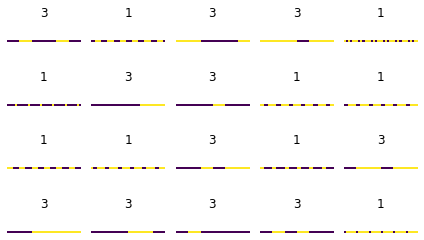

In [13]:
#################################### Input Data ################################
phase_dataset = qaml.datasets.PhaseState(DATA_SIZE,labeled=True,
                                         transform=qaml.datasets.ToSpinTensor(),
                                         target_transform=qaml.datasets.ToSpinTensor())
TRAIN = len(phase_dataset)*2//3
SPLIT = TRAIN,len(phase_dataset)-TRAIN
train_dataset,test_dataset = torch.utils.data.random_split(phase_dataset,[*SPLIT])

train_sampler = torch.utils.data.RandomSampler(train_dataset,replacement=False)
train_loader = torch.utils.data.DataLoader(train_dataset,sampler=train_sampler,batch_size=BATCH_SIZE)

test_sampler = torch.utils.data.RandomSampler(test_dataset,replacement=False)
test_loader = torch.utils.data.DataLoader(test_dataset,sampler=test_sampler,batch_size=BATCH_SIZE)

# Visualize
fig,axs = plt.subplots(4,5)
for ax,(img,label) in zip(axs.flat,train_dataset):
    ax.matshow(img.view(1,-1))
    ax.set_title(int(label))
    ax.axis('off')
plt.tight_layout()


In [6]:
################################## Model Training ##############################
bm.train()
p_log = []
r_log = []
err_log = []
score_log = []
epoch_err_log = []

for t in range(10):
    epoch_error = torch.Tensor([0.])
    for train_data, train_label in train_loader:

        input_data = torch.cat((train_data,train_label),axis=1)
        # Positive Phase
        v0, h0 = pos_sampler(input_data.flatten(),num_reads=POS_READS)

        # Negative Phase
        vk, hk = neg_sampler(num_reads=NEG_READS)

        # Compute error
        err = ML.apply(neg_sampler,(v0,h0),(vk,hk),*bm.parameters())
        optimizer.zero_grad()

        # Compute gradients
        err.backward()

        # Update parameters
        optimizer.step()

        epoch_error += err
        err_log.append(err.item())

    epoch_err_log.append(epoch_error.item())
    # Error Log
    epoch_err_log.append(epoch_error.item())
    print(f"Epoch {t} Reconstruction Error = {epoch_error.item()}")
    # Samples score
    vk,_ = neg_sampler(num_reads=TEST_READS)
    precision, recall, score = phase_dataset.score((vk[:,:DATA_SIZE]+1)/2)
    p_log.append(precision); r_log.append(recall); score_log.append(score)
    print(f"Precision {precision:.2} Recall {recall:.2} Score {score:.2}")


Epoch 0 Reconstruction Error = 3.6061902046203613
Precision 0.95 Recall 0.031 Score 0.061
Epoch 1 Reconstruction Error = 6.2347612380981445
Precision 0.3 Recall 0.094 Score 0.14
Epoch 2 Reconstruction Error = 4.8080949783325195
Precision 0.25 Recall 0.031 Score 0.056
Epoch 3 Reconstruction Error = 3.0999999046325684
Precision 0.4 Recall 0.062 Score 0.11
Epoch 4 Reconstruction Error = 2.760000228881836
Precision 0.1 Recall 0.031 Score 0.048
Epoch 5 Reconstruction Error = 3.3247618675231934
Precision 0.8 Recall 0.094 Score 0.17
Epoch 6 Reconstruction Error = 5.990952491760254
Precision 0.25 Recall 0.062 Score 0.1
Epoch 7 Reconstruction Error = 2.5428571701049805
Precision 0.1 Recall 0.031 Score 0.048
Epoch 8 Reconstruction Error = 3.1723809242248535
Precision 0.05 Recall 0.031 Score 0.038
Epoch 9 Reconstruction Error = 4.8990478515625
Precision 0.1 Recall 0.062 Score 0.077


Text(0.5, 0, 'Epoch')

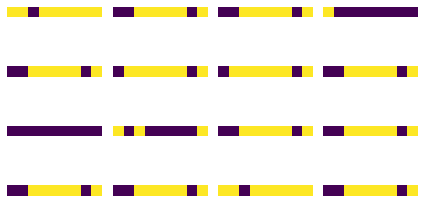

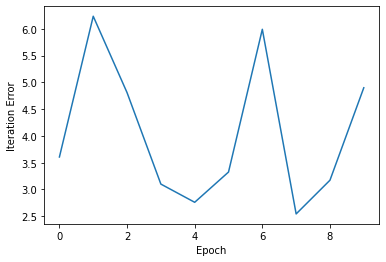

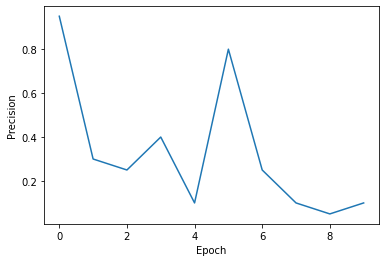

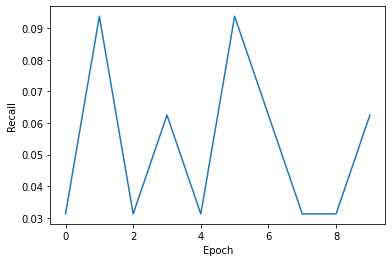

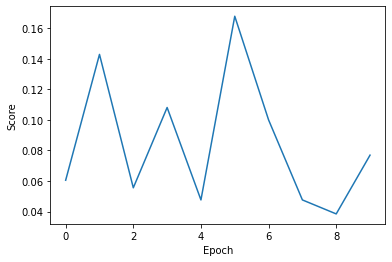

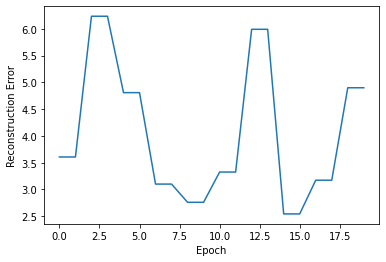

In [7]:
# Samples
fig,axs = plt.subplots(4,4)
for ax,img in zip(axs.flat,vk):
    ax.matshow(img.view(*SHAPE),vmin=0,vmax=1); ax.axis('off')
plt.tight_layout()

# Iteration Error
fig, ax = plt.subplots()
ax.plot(err_log)
plt.ylabel("Iteration Error")
plt.xlabel("Epoch")

# Precision graph
fig, ax = plt.subplots()
ax.plot(p_log)
plt.ylabel("Precision")
plt.xlabel("Epoch")


# Recall graph
fig, ax = plt.subplots()
ax.plot(r_log)
plt.ylabel("Recall")
plt.xlabel("Epoch")


# Score graph
fig, ax = plt.subplots()
ax.plot(score_log)
plt.ylabel("Score")
plt.xlabel("Epoch")


# L1 error graph
fig, ax = plt.subplots()
ax.plot(epoch_err_log)
plt.ylabel("Reconstruction Error")
plt.xlabel("Epoch")
